# Modelos de clasificación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

Como primer paso analizamos la posible correlación entre los ratios obtenidos en el notbook ratios

In [2]:
df = pd.read_csv("../tablas/dataformodel.csv", usecols=['quantile_PER', 'var_quantile_PER',
                                                        'quantile_PBC', 'var_quantile_PBC',
                                                        'quantile_ROA', 'var_quantile_ROA',
                                                        'quantile_ROE', 'var_quantile_ROE',
                                                        'quantile_DeudaCP_FFPP', 'var_quantile_DeudaCP_FFPP',
                                                        'Etiqueta','Sector'])

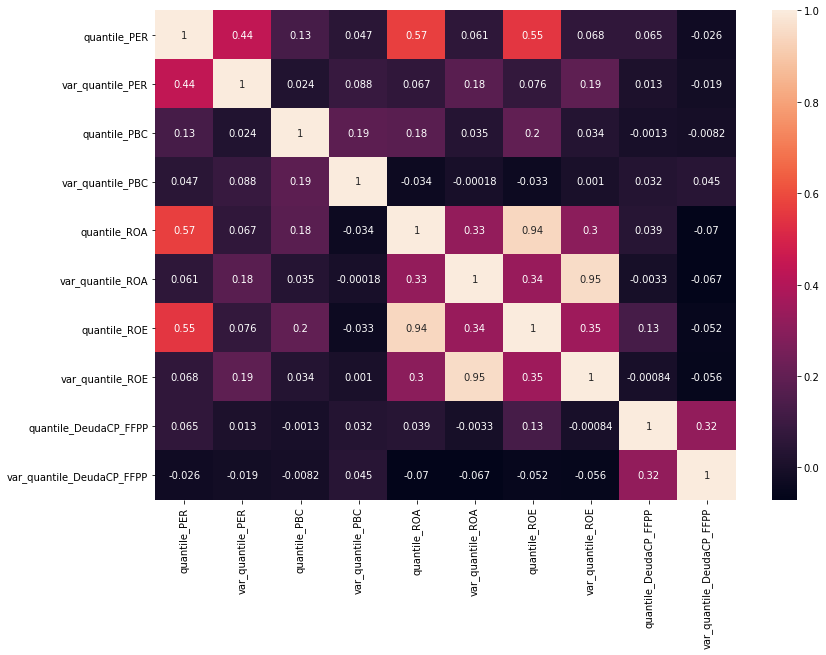

In [3]:
df = df[df.Sector=='Healthcare']

df = df[['quantile_PER', 'var_quantile_PER',
        'quantile_PBC', 'var_quantile_PBC',
        'quantile_ROA', 'var_quantile_ROA',
        'quantile_ROE', 'var_quantile_ROE',
        'quantile_DeudaCP_FFPP', 'var_quantile_DeudaCP_FFPP',
        'Etiqueta']]

corrMatrix = df.corr()
plt.figure(figsize=(13,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Podemos observar una correlación muy fuerte entre el ROE y el ROA, así que prescindimos del ROE, así como de su variación.

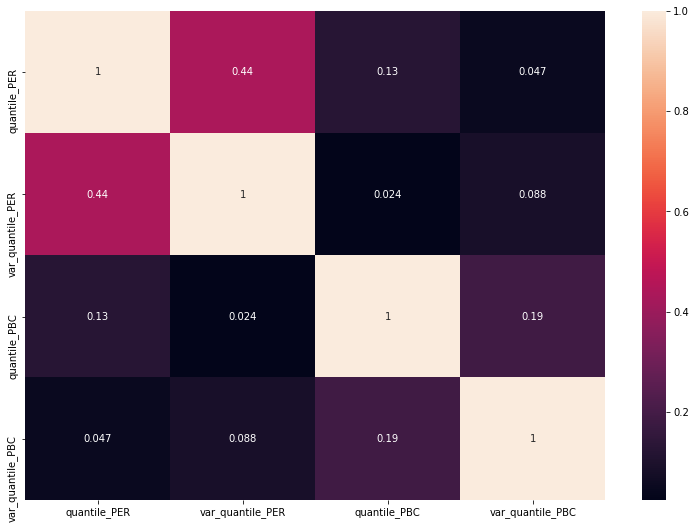

In [4]:
df = df[['quantile_PER', 'var_quantile_PER',
        'quantile_PBC', 'var_quantile_PBC',
        'Etiqueta']]

corrMatrix = df.corr()
plt.figure(figsize=(13,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Eliminamos nans

In [5]:
df=df.replace([np.inf, -np.inf], np.nan)
for column in df.columns:
    df=df[df[column].notnull()]
df=df.reset_index(drop=True)

In [6]:
df.describe()

,quantile_PER,var_quantile_PER,quantile_PBC,var_quantile_PBC
count,2020.000000,2020.000000,2020.000000,2020.000000
mean,47.628037,0.004969,60.282810,-0.183952
std,30.742335,26.696197,26.265096,9.648811
min,0.223214,-97.989573,0.671141,-81.458233
25%,18.016202,-5.870605,39.878209,-3.482616
50%,47.982022,0.000000,64.053722,0.222216
75%,75.892857,6.571559,81.859410,3.794643
max,99.324324,97.749759,99.330357,60.491071


## Preparación del modelo

In [7]:
variables = list(df.columns)
variables.remove('Etiqueta')
X = df[variables].values
y = df['Etiqueta']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, shuffle=False)

### LogisticRegression

In [9]:
from sklearn.linear_model import LogisticRegression
# Create an instance of the classifier
clf=LogisticRegression(max_iter=200)

In [10]:
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
cross_val_score(clf,X_train,y_train,cv=10,scoring="accuracy").mean()

0.5377501725327811

In [12]:
a=df.groupby('Etiqueta').count()
a['%']= a.iloc[0:,1]/a.iloc[0:,1].sum()
a

,quantile_PER,var_quantile_PER,quantile_PBC,var_quantile_PBC,%
Etiqueta,,,,,
Mejor,919,919,919,919,0.45495
Peor,1101,1101,1101,1101,0.54505


In [13]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.66      0.23      0.35       205
        Peor       0.53      0.87      0.66       199

    accuracy                           0.55       404
   macro avg       0.59      0.55      0.50       404
weighted avg       0.59      0.55      0.50       404



In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, clf.predict(X_test))
print(confusion_matrix)

[[ 48 157]
 [ 25 174]]


In [15]:
clf.score(X_test, y_test)

0.5495049504950495

### Kneighbors

In [16]:
# Load the library
from sklearn.neighbors import KNeighborsClassifier
# Create an instance of the classifier
clfk=KNeighborsClassifier(n_neighbors=5)
# Fit the data
clfk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
knGrid = GridSearchCV(clfk,cv=5,scoring="accuracy",param_grid={'n_neighbors':np.arange(1,20)})
knGrid.fit(X_train,y_train)
knGrid.best_params_

{'n_neighbors': 1}

In [19]:
best_n_neighbors=knGrid.best_params_.get('n_neighbors')

In [20]:
clfk=KNeighborsClassifier(n_neighbors=best_n_neighbors)
clfk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [21]:
cross_val_score(clfk,X_train,y_train,cv=5,scoring="accuracy").mean()

0.5315617475060199

In [22]:
print(classification_report(y_test,clfk.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.49      0.44      0.47       205
        Peor       0.48      0.53      0.51       199

    accuracy                           0.49       404
   macro avg       0.49      0.49      0.49       404
weighted avg       0.49      0.49      0.49       404



In [23]:
clfk.score(X_test, y_test, sample_weight=None)

0.4876237623762376

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, clfk.predict(X_test))
print(confusion_matrix)

[[ 91 114]
 [ 93 106]]


### Decision Tree

In [25]:
# Import library
from sklearn.tree import DecisionTreeClassifier

In [26]:
clfTree = GridSearchCV(DecisionTreeClassifier(),
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,1)},
                      cv=5,
                       scoring="accuracy"
                      )
clfTree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
       

In [27]:
clfTree.best_score_

0.5526201123724344

In [28]:
clfTree.best_params_

{'max_depth': 9, 'min_samples_leaf': 7}

In [29]:
best_max_depth=clfTree.best_params_.get('max_depth')
best_min_samples_leaf=clfTree.best_params_.get('min_samples_leaf')

In [30]:
clfTree = DecisionTreeClassifier(random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
clfTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [31]:
 clfTree.score(X_test, y_test, sample_weight=None)

0.48514851485148514

In [32]:
print(classification_report(y_test,clfTree.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.48      0.23      0.32       205
        Peor       0.49      0.74      0.59       199

    accuracy                           0.49       404
   macro avg       0.49      0.49      0.45       404
weighted avg       0.49      0.49      0.45       404

